In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import chardet
import ast
import re
from gensim.parsing.preprocessing import remove_stopwords
import collections 
import itertools
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense
from scipy.sparse import csr_matrix


In [3]:
reviews_train =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/train.csv")
reviews_test =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/test.csv")

In [4]:
np.set_printoptions(suppress=True)

# **PART 0 -- PREPROCESSING**

In [5]:

reviews_train = reviews_train.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 4', 1)

reviews = reviews_train.append(reviews_test) #appending both the datasets at 
reviews = reviews.reset_index(drop=True) 

'''removing rows with na values'''
reviews = reviews.dropna() #843 978 1755 1961 have values for "Unnamed: 3" 

'''removing rows with no text for overview'''
reviews = reviews[reviews['overview'].str.contains('[A-Za-z]')]

In [6]:
reviews.shape

(2990, 3)

In [7]:
reviews.tail()

,id,genres,overview
2995,2996,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Military men Rock Reilly and Eddie Devane are ...
2996,2997,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",Three girls in 1980s Stockholm decide to form ...
2997,2998,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...","Samantha Caine, suburban homemaker, is the ide..."
2998,2999,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Reuben Feffer is a guy who's spent his entire ...
2999,3000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",A young man sets out to uncover the truth abou...


In [8]:
'''MODIFYING GENRES FOR REVIEWS'''

for index, row in reviews.iterrows():
  genres = ast.literal_eval(row['genres'])
  st = '' 
  for genre in genres:
    st += f"{genre['name']},"
  st = st[0:-1] 
  reviews.loc[index,'genres'] = st


In [9]:
reviews.head()

,id,genres,overview
0,1,Comedy,"When Lou, who has become the ""father of the In..."
1,2,"Comedy,Drama,Family,Romance",Mia Thermopolis is now a college graduate and ...
2,3,Drama,"Under the direction of a ruthless instructor, ..."
3,4,"Thriller,Drama",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4,5,"Action,Thriller",Marine Boy is the story of a former national s...


**Finding movie by genre popularity in dataset**

In [10]:
genre_count = collections.Counter(itertools.chain.from_iterable(v.split(',') for v in reviews.genres))

genre_count_df = pd.DataFrame({'Genre': list(genre_count.keys()), 
                              'Count': list(genre_count.values())})

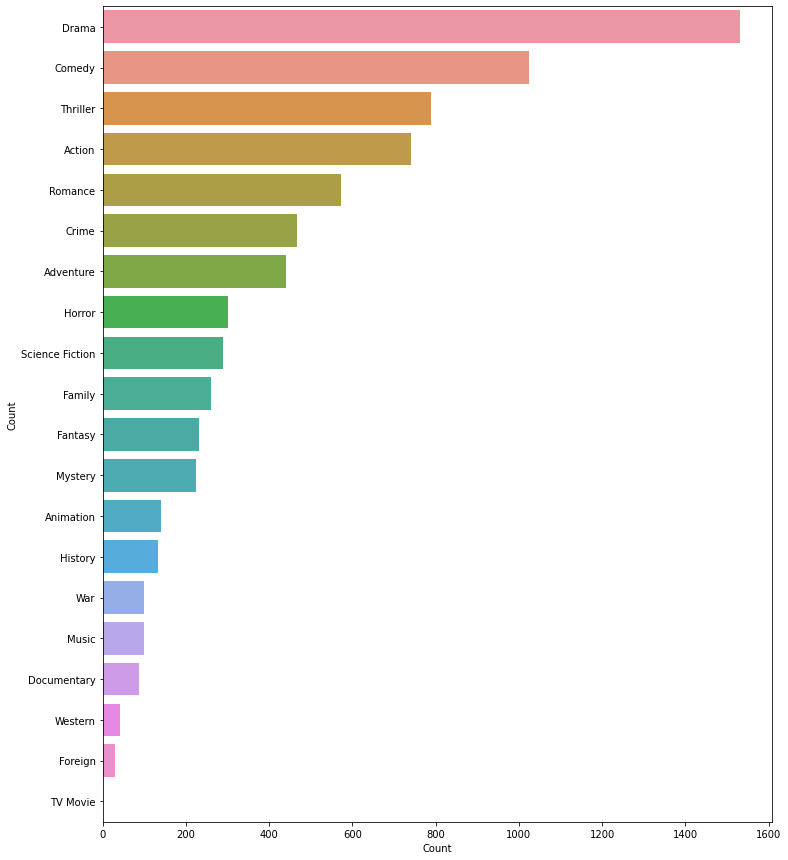

In [11]:
g = genre_count_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [13]:
y_dummy = reviews['genres'].str.get_dummies(sep=',')

y_dummy.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [14]:
y = y_dummy.values

In [15]:
y.shape

(2990, 20)

in this section, we will clean up the overview part of the input of our problem

In [16]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



def final_clean(text):
      return gensim.utils.simple_preprocess (text)


In [17]:
X = reviews['overview']

X = X.apply(lambda x: clean_text(x))

X = X.apply(remove_stopwords)


#X_w2v = X.apply(lambda x: final_clean(x))

In [18]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(reviews['genres'].str.split(',')) #THIS WILL BE USED FOR INVERSE TRANSFORM

#multilabel_binarizer.inverse_transform(y)[3]

MultiLabelBinarizer(classes=None, sparse_output=False)

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=9)

In [20]:
print("**** Y TRAIN HEAD ****\n")
print(*multilabel_binarizer.inverse_transform(ytrain)[0:20],sep='\n')
print("\n")
print(f"{(ytrain)[0:20]}\n\n\n\n\n")

print("**** Y TEST HEAD ****")
print(*multilabel_binarizer.inverse_transform(ytest)[0:20],sep='\n')
print("\n")
print((ytest)[0:20])

**** Y TRAIN HEAD ****

('Drama',)
('Comedy',)
('Fantasy', 'Horror', 'Science Fiction')
('Action', 'Adventure', 'Science Fiction')
('Comedy', 'Romance')
('Horror', 'Mystery', 'Thriller')
('Action', 'Adventure', 'Comedy', 'Drama')
('Comedy', 'Drama', 'Romance')
('Comedy',)
('Horror',)
('Horror',)
('Comedy', 'Drama', 'Romance')
('Adventure', 'Drama')
('Adventure', 'Fantasy', 'Thriller')
('Comedy', 'Drama', 'Thriller')
('Drama', 'Romance')
('Comedy',)
('Drama', 'Thriller')
('Action', 'Drama', 'Horror', 'Science Fiction', 'Thriller')
('Western',)


[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]
 [1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0

# **PART1 -- WORD2VEC**

In [21]:
SIZE = 150
WINDOW = 10

In [23]:
#note that since Word2Vec is considered an 'unsupervised' algorithm, so at 
#least during its training, it is not typical to hold back any 'test' data for
#later evaluation.
x_w2v = X.apply(lambda x: final_clean(x))
w2v_model = gensim.models.Word2Vec (x_w2v, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model.train(x_w2v,total_examples=len(x_w2v),epochs=10)




(742584, 837390)

In [26]:
w1 = "love"
w2v_model.wv.most_similar (positive=w1)

[('falls', 0.9947726726531982),
 ('woman', 0.9939749836921692),
 ('yamuna', 0.9927327036857605),
 ('torrid', 0.9921870827674866),
 ('tells', 0.9920265078544617),
 ('telling', 0.9919995665550232),
 ('cursed', 0.9919919371604919),
 ('unsuspecting', 0.9913012981414795),
 ('married', 0.9910011887550354),
 ('true', 0.990985631942749)]

below, we find the feature values for each document by summing over the word features then dividing by the number of words

In [27]:
x_vec_w2v = np.zeros((len(x_w2v), SIZE))

for idx, paragraph in enumerate(x_w2v): 
  ln = len(paragraph)
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      arr = w2v_model[word] + arr
  
    except KeyError:
      ln -= 1
  arr = arr/ln 
  x_vec_w2v[idx,:] = arr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [28]:
x_vec_w2v

array([[0.12878917, 0.02568264, 0.56623371, ..., 0.07906572, 0.33364169,
        0.16641991],
       [0.11788176, 0.01636379, 0.51831766, ..., 0.07221431, 0.29773221,
        0.14446398],
       [0.1013018 , 0.01978399, 0.45379835, ..., 0.05826371, 0.25236787,
        0.12559693],
       ...,
       [0.11695513, 0.0911711 , 0.57302194, ..., 0.09962571, 0.33514345,
        0.13463641],
       [0.12778736, 0.01042771, 0.56063358, ..., 0.0678862 , 0.3135784 ,
        0.15848497],
       [0.13594157, 0.0255404 , 0.60051087, ..., 0.07285361, 0.33872547,
        0.16379221]])

In [29]:
xtrain_w2v, xtest_w2v, ytrain_w2v, ytest_w2v = train_test_split(x_vec_w2v, y, test_size=0.15, random_state=9) #now do splitting for classification
                                #note that since parameters same as split above, the y's will be the same as before (ytrain_w2v == ytrain)

**LOGISTIC REGRESSION WITH 1VSALL**

In [31]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_w2v, ytrain_w2v)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [57]:
y_pred_prob_trn = clf.predict_proba(xtrain_w2v)
y_pred_prob_tst = clf.predict_proba(xtest_w2v)

t = 0.245 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)


In [55]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest_w2v)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Comedy', 'Drama', 'Thriller')


In [58]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"train set f-score: {f1_score(ytrain, y_pred_lr_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")


*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
train set f-score: 0.44372904091213955
test set f-score: 0.4531607006854532


**NEURAL NETWORK**

In [59]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 

x_train, y_train = xtrain_w2v, ytrain_w2v
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=100)


In [72]:
nn_y_pred_trn = model.predict(xtrain_w2v)
nn_y_pred_tst = model.predict(xtest_w2v)

THRESHOLD = 0.27
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [73]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"training set f-score: {f1_score(ytrain_w2v, nn_y_pred_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest_w2v, nn_y_pred_tst, average='micro')}")

*** NUERAL NET CLASSIFIER ***
training set f-score: 0.4428690575479566
test set f-score: 0.4551231135822081


# **PART 2 -- TFIDF**

In [74]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [75]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

csr_matrix.sort_indices(xtrain_tfidf)
csr_matrix.sort_indices(xtest_tfidf)

**LOGISTIC REGRESSION WITH 1VSALL**

In [76]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [77]:
y_pred_prob_trn = clf.predict_proba(xtrain_tfidf)
y_pred_prob_tst = clf.predict_proba(xtest_tfidf)

t = 0.225 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)

In [78]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Drama', 'Thriller')


In [79]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"training set f-score:{f1_score(ytrain, y_pred_lr_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")


*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
training set f-score:0.6858060630395503
test set f-score: 0.5528021349599694


**NEURAL NETWORK**

In [80]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 

x_train, y_train = xtrain_tfidf, ytrain
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 20), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


In [81]:
#csr_matrix.sort_indices(xtest_tfidf)
nn_y_pred_trn = model.predict(xtrain_tfidf)
nn_y_pred_tst = model.predict(xtest_tfidf)

In [82]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_tfidf) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22477018879114363
threshold: 0.05 --- score: 0.5520745131244709
threshold: 0.1 --- score: 0.5486645540968764
threshold: 0.15000000000000002 --- score: 0.5379506641366224
threshold: 0.2 --- score: 0.5356793743890519
threshold: 0.25 --- score: 0.5237381309345327
threshold: 0.3 --- score: 0.5134449518011162
threshold: 0.35 --- score: 0.5041407867494824
threshold: 0.39999999999999997 --- score: 0.49178590355060936
threshold: 0.44999999999999996 --- score: 0.4805194805194805


In [83]:
THRESHOLD = 0.05
nn_y_pred_trn = (nn_y_pred_trn> THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst> THRESHOLD).astype(int)

In [84]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"training set f-score: {f1_score(ytrain, nn_y_pred_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, nn_y_pred_tst, average='micro')}")


*** NUERAL NET CLASSIFIER ***
training set f-score: 0.9996076892899176
test set f-score: 0.5520745131244709
